In [ ]:
import pandas as pd
df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\api-data-explorer\analysis\data\기간별통계_20190601~20250228.csv")

# df.rename(columns={"총관객수": "총티켓판매수"}, inplace=True)
# df.to_csv("기간별통계_20190601~20250228.csv", index=False, encoding="utf-8-sig")

print(df.columns)
df

Index(['날짜/요일', '개막편수', '상연횟수', '매출액', '총티켓판매수', '공연건수', '판매수', '취소수'], dtype='object')


,날짜/요일,개막편수,상연횟수,매출액,총티켓판매수,공연건수,판매수,취소수
0,20190601,49,278,1160615330,30430,154,41486,11056
1,20190602,8,174,615280060,15751,110,21486,5735
2,20190603,1,16,1534000,282,12,426,144
3,20190604,12,61,67583340,4238,53,5934,1696
4,20190605,16,80,121863090,5942,67,9106,3164
...,...,...,...,...,...,...,...,...
2095,20250224,10,88,62774240,4110,58,5486,1376
2096,20250225,22,188,1124164100,21952,143,34291,12339
2097,20250226,32,269,1744235434,35435,185,57085,21650
2098,20250227,41,274,1305590154,34560,210,53451,18891


In [19]:
# 총티켓판매수 컬럼 생성
# 매출액 / 총티켓판매수
# 총티켓판매수가 0인 경우를 대비하여 0으로 나누기 방지

df["평균티켓단가"] = np.where(
    df["총티켓판매수"] != 0,
    df["매출액"] / df["총티켓판매수"],
    0
)
summary_stats = df["평균티켓단가"].describe()
print(summary_stats)

df = df.rename(columns={"날짜/요일":"날짜"})

df.to_csv("기간별통계간별통계(평균티켓단가)201906~202502.csv", index=False, encoding="utf-8-sig")
df

count      2100.000000
mean      44988.990709
std       18502.026769
min        3001.807940
25%       32997.091487
50%       44744.022712
75%       56956.382744
max      142163.086715
Name: 평균티켓단가, dtype: float64


,날짜,개막편수,상연횟수,매출액,총티켓판매수,공연건수,판매수,취소수,평균티켓단가
0,20190601,49,278,1160615330,30430,154,41486,11056,38140.497207
1,20190602,8,174,615280060,15751,110,21486,5735,39062.920449
2,20190603,1,16,1534000,282,12,426,144,5439.716312
3,20190604,12,61,67583340,4238,53,5934,1696,15946.989146
4,20190605,16,80,121863090,5942,67,9106,3164,20508.766409
...,...,...,...,...,...,...,...,...,...
2095,20250224,10,88,62774240,4110,58,5486,1376,15273.537713
2096,20250225,22,188,1124164100,21952,143,34291,12339,51210.099308
2097,20250226,32,269,1744235434,35435,185,57085,21650,49223.520079
2098,20250227,41,274,1305590154,34560,210,53451,18891,37777.492882


# ARIMA

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import math

df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\api-data-explorer\analysis\기간별통계간별통계(평균티켓단가)201906~202502.csv")

# 날짜를 시계열 index로 설정
df['날짜'] = pd.to_datetime(df['날짜'].astype(str), format='%Y%m%d')
df.set_index('날짜', inplace=True)
df = df.asfreq('D')

# 이상치 제거 : asfreq('D')로 인해 없는 날짜에 행이 생겨 NAN이 발생할 수 있음
df['평균티켓단가'] = df['평균티켓단가'].interpolate(method='time') # 시계열 보간
df['매출액'] = df['매출액'].interpolate(method='time')

# 훈련/테스트 분할
train_ratio = 0.8
split_idx = int(len(df)*train_ratio)
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

# 로그 변환
train_price_log = np.log1p(df_train['평균티켓단가'])
test_price_log = np.log1p(df_test['평균티켓단가'])

# ARIMA 평균티켓단가 예측 모델링
model_price = ARIMA(df_train['평균티켓단가'], order=(1,1,1)) # (p,d,q)
model_price_fit = model_price.fit()

# 예측 (out-of-sample forecast)
price_forecast = model_price_fit.forecast(steps=len(df_test))
price_forecast = np.expm1(price_forecast) # 로그 역변환

# 로그 변환
train_price_log = np.log1p(df_train['매출액'])
test_price_log = np.log1p(df_test['매출액'])

# ARIMA 매출액 예측 모델링
model_sales = ARIMA(df_train['매출액'], order=(1,1,1)) # (p,d,q)
model_sales_fit = model_sales.fit()

sales_forecast = model_sales_fit.forecast(steps=len(df_test))
#sales_forecast = np.expm1(sales_forecast)

# 예측 성능 평가 (RMSE 등)
rmse_price = math.sqrt(mean_squared_error(df_test['평균티켓단가'], price_forecast))
rmse_sales = math.sqrt(mean_squared_error(df_test['매출액'], sales_forecast))
print("RMSE (평균티켓단가):", rmse_price)
print("RMSE (매출액)):", rmse_sales)

if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') # Windows: 맑은 고딕
elif platform.system() == 'Darwin': # macOS
    plt.rc('font', family='AppleGothic')

# 시각화
plt.figure(figsize=(12,6))

# 평균티켓단가 시각화
plt.subplot(2,1,1)
plt.plot(df_test.index, df_test['평균티켓단가'], label='실제 평균티켓단가', color='blue')
plt.plot(df_test.index, price_forecast, label='예측 평균티켓단가', color='red', linestyle='--')
plt.title("평균티켓단가 ARIMA 예측")
plt.legend()

# 매출액 시각화
plt.subplot(2,1,2)
plt.plot(df_test.index, df_test['매출액'], label='실제 매출액', color='blue')
plt.plot(df_test.index, sales_forecast, label='예측 매출액', color='red', linestyle='--')
plt.title('매출액 ARIMA 예측')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [46]:
print("Any NaN in price_forecast?", np.isnan(price_forecast).any())
print("Any Inf in price_forecast?", np.isinf(price_forecast).any())


Any NaN in price_forecast? False
Any Inf in price_forecast? True


In [41]:
print(model_price_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 평균티켓단가   No. Observations:                 1680
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -18690.807
Date:                Wed, 26 Mar 2025   AIC                          37387.615
Time:                        00:16:32   BIC                          37403.893
Sample:                    06-01-2019   HQIC                         37393.645
                         - 01-05-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0759      0.031      2.472      0.013       0.016       0.136
ma.L1         -0.9615      0.009   -104.518      0.000      -0.980      -0.944
sigma2       3.36e+08   7.47e-12    4.5e+19      0.0

c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


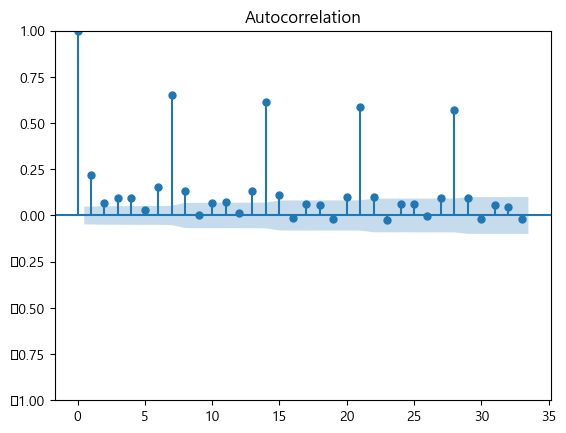

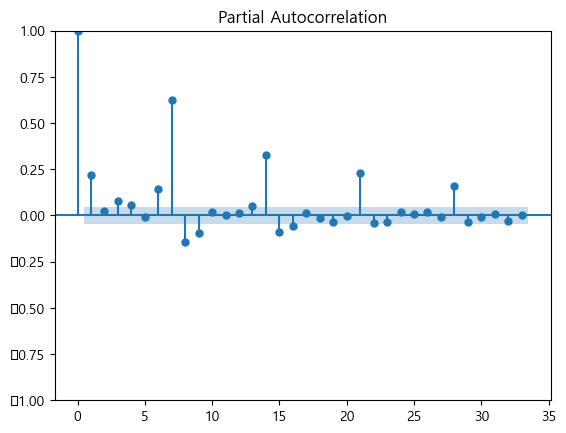

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_train['평균티켓단가'])
plot_pacf(df_train['평균티켓단가'])
plt.show()


# LSTM

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [74]:
df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\api-data-explorer\analysis\기간별통계간별통계(평균티켓단가)201906~202502.csv")

df['날짜'] = pd.to_datetime(df['날짜'].astype(str), format='%Y%m%d')
df.set_index('날짜', inplace=True)

# 일자 빈도로 맞추기 - 결측치 
df = df.asfreq('D')
print(df.info())

# 결측치 보간/제거
df['평균티켓단가'] = df['평균티켓단가'].interpolate(method='time')
df['매출액'] = df['매출액'].interpolate(method='time')
# df = df.dropna()

# 넘파이 배열로 추출
y = df['평균티켓단가'].values # shape: (2100, )

# 스케일링
scaler = MinMaxScaler(feature_range=(0,1))
y_scaled = scaler.fit_transform(y.reshape(-1,1)) # shape: (2100,1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2019-06-01 to 2025-02-28
Freq: D
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   개막편수    2100 non-null   int64  
 1   상연횟수    2100 non-null   int64  
 2   매출액     2100 non-null   int64  
 3   총티켓판매수  2100 non-null   int64  
 4   공연건수    2100 non-null   int64  
 5   판매수     2100 non-null   int64  
 6   취소수     2100 non-null   int64  
 7   평균티켓단가  2100 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 147.7 KB
None


In [ ]:
# 시퀀스 데이터셋 생성
# LSTM은 과거 lookback 타임스템을 입력으로 받아, 그다음 시점(단일 스템)을 예측함
# 이를 위해 (X, Y) 쌍을 만들어야 한다.

def create_sequences(series, lookback=30):
    # series: (N,1) 모양의 스케일된 시계열
    # lookback: 과거 몇 일 데이터를 볼지
    X, Y = [], []
    for i in range(len(series) - lookback):
        seq_x = series[i : i+lookback, 0] # (Lookback, 0)
        seq_y = series[i+lookback, 0] # 스칼라
        X.append(seq_x)
        Y.append(seq_y)
    X = np.array(X) # (N-Lookback, Lookback)
    Y = np.array(Y) # (N-Lookback,)
    return X, Y

lookback = 30
X_all, Y_all = create_sequences(y_scaled, lookback=lookback)
print("X_all.shape:", X_all.shape)
print("Y_all.shape:", Y_all.shape)

X_all.shape: (2070, 30)
Y_all.shape: (2070,)


In [60]:
# 훈련/테스트 분할

train_ratio = 0.8
train_size = int(len(X_all) * train_ratio)

X_train = X_all[:train_size]
Y_train = Y_all[:train_size]
X_test = X_all[train_size:]
Y_test = Y_all[train_size:]

print("Train size:", X_train.shape, Y_train.shape)
print("Test size:", X_test.shape, Y_test.shape)

Train size: (1656, 30) (1656,)
Test size: (414, 30) (414,)


In [68]:
# PyTorch Dataset 정의

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        # X: (sample, Lookback)
        # Y: (sample,)
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # LSTM 입력은 3D: (batch, seq_len, features)
        # 현재 X[idx]는 shape (Lookback,) 이므로, (Lookback, 1)로 reshape
        x_seq = self.X[idx].reshape(-1, 1) # (Lookback, 1)
        y_val = self.Y[idx] # 스칼라
        return x_seq, y_val

# dataset 생성
train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset = TimeSeriesDataset(X_test, Y_test)

# DataLoader (batch_size 설정)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [69]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM
        # batch_first=True -> 입력 shape: (batch, seq_len, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 최종 예측을 위한 fully-connected
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)

        # LSTM 순전파
        # out: (batch, seq_len, hidden_size)
        # (h_n, c_n): LSTM 최종 히든/셀 상태
        out, (h_n, c_n) = self.lstm(x)

        # 마지막 시점의 hidden state만 사용
        # out(:, -1, :) => (batch, hidden_size)
        last_hidden = out[:, -1, :]

        # FC 레이어로 출력 => (batch, 1)
        y_pred = self.fc(last_hidden)
        return y_pred

In [70]:
# 모델 초기화 및 학습 루프
# GPU 선택사항
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTMModel(input_size=1, hidden_size=50, num_layers=1)
model.to(device)

# 손실함수 & 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, Y_batch in train_loader:
        # X_batch: (batch, Lookback, 1), Y_batch: (batch,)
        X_batch = X_batch.float().to(device)
        Y_batch = Y_batch.float().to(device)

        # 순전파
        outputs = model(X_batch) # (batch, 1)
        loss = criterion(outputs.squeeze(), Y_batch) # squeeze()로 (batch,) 맞춤

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # (선택) 검증셋에 대한 손실도 계산
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.float().to(device)
            Y_batch = Y_batch.float().to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), Y_batch)
            test_loss += loss.item() * X_batch.size(0)
    test_loss /= len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.6f} Test Loss: {test_loss:.6f}")

Using device: cpu
Epoch [1/30] Train Loss: 0.043520 Test Loss: 0.027323
Epoch [2/30] Train Loss: 0.015417 Test Loss: 0.023878
Epoch [3/30] Train Loss: 0.015465 Test Loss: 0.024722
Epoch [4/30] Train Loss: 0.015198 Test Loss: 0.024423
Epoch [5/30] Train Loss: 0.015218 Test Loss: 0.023315
Epoch [6/30] Train Loss: 0.015105 Test Loss: 0.023065
Epoch [7/30] Train Loss: 0.015036 Test Loss: 0.027310
Epoch [8/30] Train Loss: 0.015346 Test Loss: 0.023763
Epoch [9/30] Train Loss: 0.014871 Test Loss: 0.024436
Epoch [10/30] Train Loss: 0.014703 Test Loss: 0.025339
Epoch [11/30] Train Loss: 0.014777 Test Loss: 0.024353
Epoch [12/30] Train Loss: 0.014578 Test Loss: 0.021567
Epoch [13/30] Train Loss: 0.014555 Test Loss: 0.021636
Epoch [14/30] Train Loss: 0.014391 Test Loss: 0.021334
Epoch [15/30] Train Loss: 0.014422 Test Loss: 0.021057
Epoch [16/30] Train Loss: 0.014484 Test Loss: 0.022411
Epoch [17/30] Train Loss: 0.014170 Test Loss: 0.022943
Epoch [18/30] Train Loss: 0.014308 Test Loss: 0.021230
E

In [71]:
# 예측(test_set) 및 역스케일링

model.eval()
preds_scaled = []
y_test_scaled = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.float().to(device)
        outputs = model(X_batch) # (batch, 1)
        preds_scaled.append(outputs.cpu().numpy())
        y_test_scaled.append(Y_batch.cpu().numpy())

preds_scaled = np.concatenate(preds_scaled) # shape: (테스트 샘플 수, 1)
y_test_scaled = np.concatenate(y_test_scaled) # shape: (테스트 샘플 수,)

# 역스케일링
preds = scaler.inverse_transform(preds_scaled) # (N_test, 1)
y_test_true = scaler.inverse_transform(y_test_scaled.reshape(-1,1)) # (N_test, 1)

# RMSE
rmse = math.sqrt(mean_squared_error(y_test_true, preds))
print("RMSE (평균티켓단가, PyTorch LSTM):", rmse)

RMSE (평균티켓단가, PyTorch LSTM): 16991.625094631974


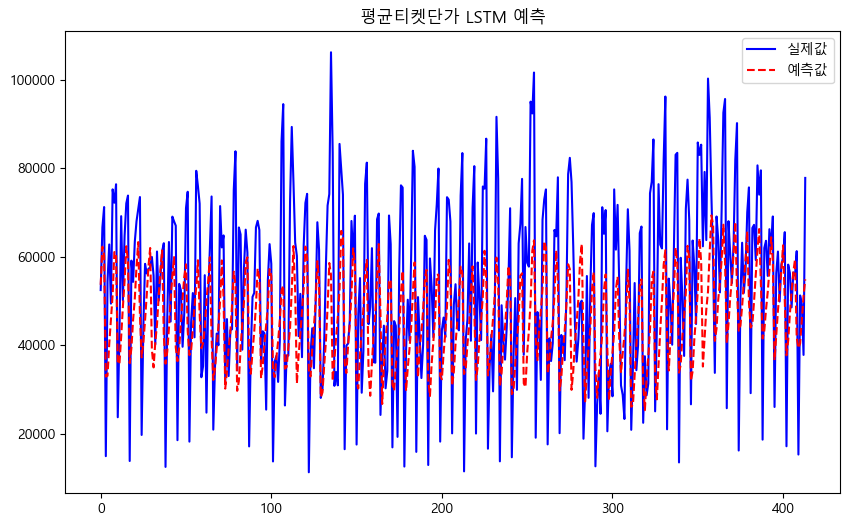

In [84]:
plt.figure(figsize=(10,6))
plt.plot(y_test_true, label='실제값', color='blue')
plt.plot(preds, label='예측값', color='red', linestyle='--')
plt.title("평균티켓단가 LSTM 예측")
plt.legend()
plt.show()

In [77]:
# 매출액 예측
y_sales = df['매출액'].values #shape (N,)

# 스케일링
scaler_sales = MinMaxScaler(feature_range=(0,1))
y_sales_scaled = scaler_sales.fit_transform(y_sales.reshape(-1,1))

# 훈련/테스트 분할

train_ratio = 0.8
train_size = int(len(X_all)*train_ratio)

X_train = X_all[:train_size]
Y_train = Y_all[:train_size]
X_test = X_all[train_size:]
Y_test = Y_all[train_size:]

# dataset 생성

train_dataset_sales = TimeSeriesDataset(X_train, Y_train)
test_dataset_sales = TimeSeriesDataset(X_test, Y_test)

batch_size = 32
train_loader_sales = DataLoader(train_dataset_sales, batch_size=batch_size, shuffle=True)
test_loader_sales = DataLoader(test_dataset_sales, batch_size=batch_size, shuffle=False)

In [78]:
# LSTM 모델 및 학습 루프

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sales = LSTMModel(input_size=1, hidden_size=50, num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_sales.parameters(), lr=0.001)

num_epochs = 30
for epoch in range(num_epochs):
    model_sales.train()
    train_loss = 0.0
    for X_batch, Y_batch in train_loader_sales:
        X_batch = X_batch.float().to(device) # (batch, Lookback, 1)
        Y_batch = Y_batch.float().to(device) # (batch,)
        outputs = model_sales(X_batch)
        loss = criterion(outputs.squeeze(), Y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*X_batch.size(0)
    train_loss /= len(train_loader_sales.dataset)

    # 검증 손실 계산
    model_sales.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader_sales:
            X_batch = X_batch.float().to(device)
            Y_batch = Y_batch.float().to(device)
            outputs = model_sales(X_batch)
            loss = criterion(outputs.squeeze(), Y_batch)
            test_loss += loss.item()*X_batch.size(0)
    test_loss /= len(test_loader_sales.dataset)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

[Epoch 1/30] Train Loss: 0.060369, Test Loss: 0.023547
[Epoch 2/30] Train Loss: 0.015293, Test Loss: 0.023928
[Epoch 3/30] Train Loss: 0.015077, Test Loss: 0.025942
[Epoch 4/30] Train Loss: 0.015019, Test Loss: 0.022699
[Epoch 5/30] Train Loss: 0.015149, Test Loss: 0.022118
[Epoch 6/30] Train Loss: 0.015050, Test Loss: 0.023252
[Epoch 7/30] Train Loss: 0.014867, Test Loss: 0.022883
[Epoch 8/30] Train Loss: 0.014953, Test Loss: 0.024864
[Epoch 9/30] Train Loss: 0.014894, Test Loss: 0.023309
[Epoch 10/30] Train Loss: 0.014771, Test Loss: 0.022116
[Epoch 11/30] Train Loss: 0.014736, Test Loss: 0.023908
[Epoch 12/30] Train Loss: 0.014446, Test Loss: 0.021167
[Epoch 13/30] Train Loss: 0.015127, Test Loss: 0.021141
[Epoch 14/30] Train Loss: 0.014959, Test Loss: 0.022176
[Epoch 15/30] Train Loss: 0.014360, Test Loss: 0.024187
[Epoch 16/30] Train Loss: 0.014129, Test Loss: 0.020575
[Epoch 17/30] Train Loss: 0.013810, Test Loss: 0.021276
[Epoch 18/30] Train Loss: 0.013213, Test Loss: 0.018049
[

RMSE (매출액, PyTorch LSTM): 2891058527.9019322


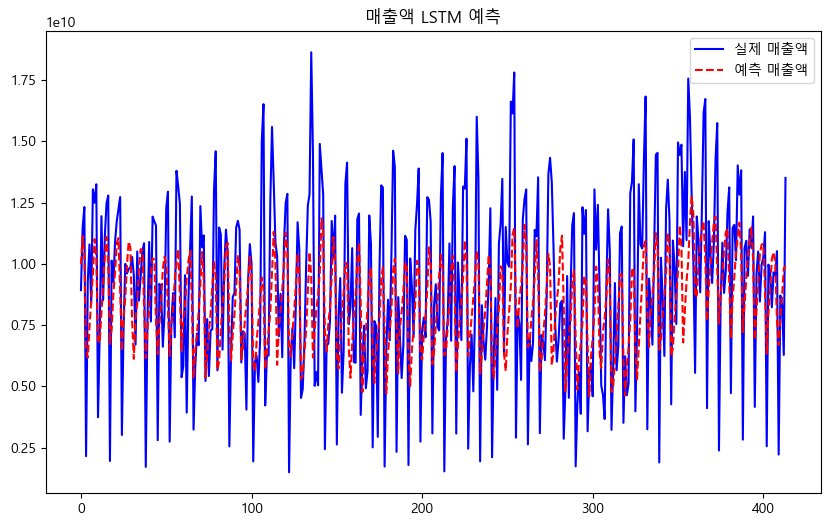

In [88]:
# 예측 및 역스케일링

model_sales.eval()
pred_sales_scaled = []
y_test_sales_scaled = []
with torch.no_grad():
    for X_batch, Y_batch in test_loader_sales:
        X_batch = X_batch.float().to(device)
        outputs = model_sales(X_batch) # (batch,1)
        pred_sales_scaled.append(outputs.cpu().numpy())
        y_test_sales_scaled.append(Y_batch.cpu().numpy())

pred_sales_scaled = np.concatenate(pred_sales_scaled) # shape: (N_test,1)
y_test_sales_scaled = np.concatenate(y_test_sales_scaled) # shape: (N_test,)

# 역변환
pred_sales = scaler_sales.inverse_transform(pred_sales_scaled)
y_test_sales = scaler_sales.inverse_transform(y_test_sales_scaled.reshape(-1,1))

# RMSE
rmse_sales = math.sqrt(mean_squared_error(y_test_sales, pred_sales))
print("RMSE (매출액, PyTorch LSTM):", rmse_sales)

# 시각화
plt.figure(figsize=(10,6))
plt.plot(y_test_sales, label='실제 매출액', color='blue')
plt.plot(pred_sales, label='예측 매출액', color='red', linestyle='--')
plt.title("매출액 LSTM 예측")
plt.legend()
plt.show()

# 분석 예시
## 사용자:
다음 분기(3개월) 동안 서울특별시 연극(장르코드 AAAA) 평균티켓단가와 매출액이 어떻게 변할지 보여줘.
그리고 최대·최소값 시점이 언제일지 알려줘.

## AI 응답(예시)

### 분석 배경

“현재 모델은 LSTM 기반 시계열 예측을 사용하며, 과거 2년간(예: 2022.01 ~ 2023.12)의 일별 데이터를 바탕으로 학습되었습니다.

서울특별시(지역코드=11), 연극(장르코드=AAAA) 데이터를 필터링해 평균티켓단가와 매출액을 각각 예측했습니다.”

### 예측 결과 요약

“향후 3개월 동안(2024.01.01 ~ 2024.03.31) 평균티켓단가는 3만 8천 원 ~ 5만 2천 원 범위에서 변동할 것으로 예상합니다.

매출액은 월 평균 10억~12억 원 사이로 추정되며, 2월 말에 가장 높은 매출(약 13억 원)일 것으로 보입니다.”

### 시각화(라인 차트)

최근 1개월 실제값과, 향후 3개월 예측값을 한 그래프에 표시

평균티켓단가 & 매출액 각각 2개 차트 or 1개 차트에 2축(y1=티켓단가, y2=매출액)로 표현 가능

예:

- 파란색 실선: 과거 실제 데이터
- 빨간색 점선: 향후 90일 예측

### 추가 코멘트

“2월 말 ~ 3월 초에 매출이 높아질 것으로 예상하니, 주말 공연 편성 확대나 티켓 프로모션을 검토해 보세요.”



In [ ]:
import platform
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

def fancy_plot_ticket_and_revenue(
    dates_actual, actual_ticket, actual_revenue,
    dates_forecast, pred_ticket, pred_revenue
):
    """
    - dates_actual: 과거 실제 데이터 날짜 배열
    - actual_ticket: 과거 실제 평균티켓단가 배열
    - actual_revenue: 과거 실제 매출액 배열
    - dates_forecast: 미래 예측 날짜 배열
    - pred_ticket: 예측된 평균티켓단가 배열
    - pred_revenue: 예측된 매출액 배열
    """

    # -----------------------------
    # (A) 한글 폰트 설정
    if platform.system() == 'Windows':
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif platform.system() == 'Darwin':
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

    # -----------------------------
    # (B) Seaborn 스타일/테마 설정
    # 'whitegrid', 'darkgrid', 'white', 'dark', 'ticks' 등 선택 가능
    sns.set_style("whitegrid")
    # Seaborn 컨텍스트: "paper", "notebook", "talk", "poster"
    # font_scale 로 글자 크기 조절
    sns.set_context("talk", font_scale=1.2)
    # Seaborn 팔레트 예: "Set2", "Pastel1", "deep", "muted", etc.
    sns.set_palette("Set2")

    # -----------------------------
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle("평균티켓단가 & 매출액 예측 결과", fontsize=18, fontweight='bold')

    # -----------------------------
    # (C) 첫 번째 Subplot: 평균티켓단가
    axes[0].plot(dates_actual, actual_ticket,
                 label='실제 평균티켓단가',
                 color='C0',   # Seaborn palette에서 첫 번째 색상
                 marker='o', markersize=4,
                 linewidth=2, alpha=0.8)
    axes[0].plot(dates_forecast, pred_ticket,
                 label='예측 평균티켓단가',
                 color='C1',   # Seaborn palette에서 두 번째 색상
                 marker='o', markersize=4,
                 linewidth=2, linestyle='--', alpha=0.8)

    axes[0].set_ylabel("평균티켓단가 (원)", fontsize=13)
    axes[0].legend()
    axes[0].set_title("평균티켓단가 (최근 vs. 예측)", fontsize=14, pad=10)

    # -----------------------------
    # (D) 두 번째 Subplot: 매출액
    axes[1].plot(dates_actual, actual_revenue,
                 label='실제 매출액',
                 color='C2',  # 세 번째 색상
                 marker='s', markersize=4,
                 linewidth=2, alpha=0.8)
    axes[1].plot(dates_forecast, pred_revenue,
                 label='예측 매출액',
                 color='C3',  # 네 번째 색상
                 marker='s', markersize=4,
                 linewidth=2, linestyle='--', alpha=0.8)

    axes[1].legend()
    axes[1].set_title("매출액 (최근 vs. 예측)", fontsize=14, pad=10)

    # (콤마 표기로 큰 숫자 표시)
    axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

    # -----------------------------
    # (E) X축 날짜 라벨 각도 조절
    plt.xticks(rotation=45)

    # -----------------------------
    # (F) Spines 제거(Seaborn despine)
    sns.despine()

    # 레이아웃 정리
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



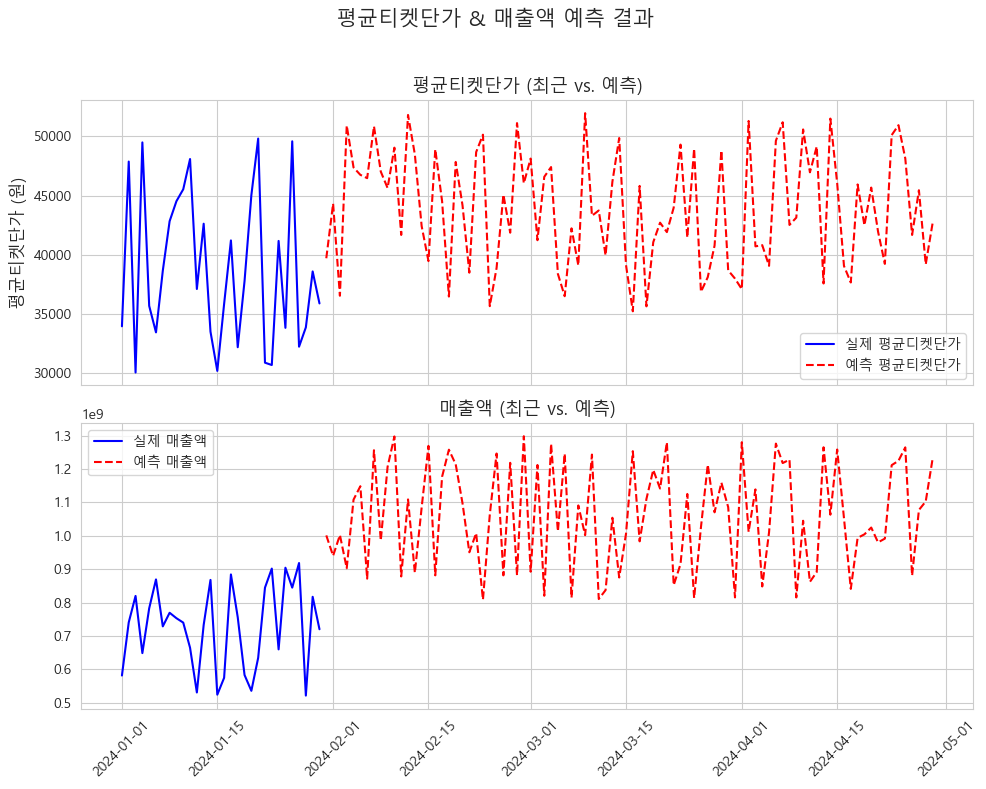

In [107]:
if __name__ == "__main__":
    import pandas as pd
    import numpy as np

    # 1) 과거 30일 (실제)
    dates_actual = pd.date_range("2024-01-01", periods=30, freq='D')
    actual_ticket = np.random.randint(30000, 50000, size=30)   # 티켓단가 예시
    actual_revenue = np.random.randint(5e8, 1e9, size=30)      # 매출액 예시(5~10억)

    # 2) 미래 90일 (예측)
    dates_forecast = pd.date_range("2024-01-31", periods=90, freq='D')
    pred_ticket = np.random.randint(35000, 52000, size=90)
    pred_revenue = np.random.randint(8e8, 1.3e9, size=90)

    # 시각화 함수 호출
    plot_ticket_and_revenue(
        dates_actual, actual_ticket, actual_revenue,
        dates_forecast, pred_ticket, pred_revenue
    )